# Libraries 

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval
from statsFuncs import compDistributions
import scipy
import random

mpl.rcParams['axes.linewidth'] = 2

# Paths 

In [43]:
fig3_path = os.getcwd()
figures_path = str(Path(fig3_path).parent)
datapath = figures_path + '/data/radiologists/trials_forward/radiologists_results/'

# Plot params 

In [44]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject loop 

Get number of subjects, which is number of folders in datapath -1 (the super subject)

In [45]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

79 files, 13 folders
12 subjects


In [46]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

## Calculate mean and error bars 

In [47]:
alldata_trimed = pd.DataFrame()
alldata = pd.DataFrame(columns=['SUBJECT', 'BOOTSTRAP_VALUES'])

row = 0
for subject in subject_names:
    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
    subjectdata_temp['BOOTSTRAP_VALUES'] = subjectdata['bootstrap_values']
    subjectdata_temp.loc[:, 'SUBJECT'] = subject
    
    print(subject)
    alldata_trimed.loc[row,'SUBJECT'] = subject
    
    mean, ci_low, ci_up = mean_confidence_interval.confidence_interval_percentile(subjectdata['bootstrap_values'])
    
    alldata_trimed.loc[row, 'BOOTSTRAP_MEAN'] = mean
    alldata_trimed.loc[row, 'BOOTSTRAP_CI_LOW'] = ci_low
    alldata_trimed.loc[row, 'BOOTSTRAP_CI_UP'] = ci_up
    
    if subject == 'S1':
        alldata = subjectdata_temp
    else:
        alldata = pd.concat([alldata, subjectdata_temp])
    
    row += 1
    

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


## Organize error bars 

In [48]:
alldata_trimed_ci = pd.DataFrame(columns= subject_names)
for i in range(len(alldata_trimed)):
    
    print(i)
    subject = alldata_trimed.loc[i, 'SUBJECT']
    low = alldata_trimed.loc[i, 'BOOTSTRAP_MEAN'] - alldata_trimed.loc[i, 'BOOTSTRAP_CI_LOW']
    up = alldata_trimed.loc[i, 'BOOTSTRAP_CI_UP'] - alldata_trimed.loc[i, 'BOOTSTRAP_MEAN'] 
    
    alldata_trimed_ci.loc[0, subject] = low
    alldata_trimed_ci.loc[1, subject] = up

0
1
2
3
4
5
6
7
8
9
10
11
12


# Plot Fig 3 

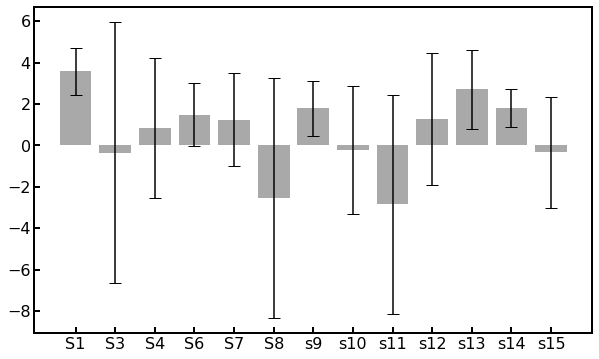

In [49]:
plt.figure(figsize=(10, 6))

plt.bar(alldata_trimed['SUBJECT'], alldata_trimed['BOOTSTRAP_MEAN'], yerr=alldata_trimed['BOOTSTRAP_CI_LOW'].to_numpy(), ecolor='black',
       capsize=6, color = 'darkgray')
plt.savefig('TrialsForward_HalfAmplitude_radiologists_v1.eps', bbox_inches='tight', dpi=1200)
plt.savefig('TrialsForward_HalfAmplitude_radiologists_v1.svg', bbox_inches='tight', dpi=1200)

## Subject 13: checking distribution and error bars 

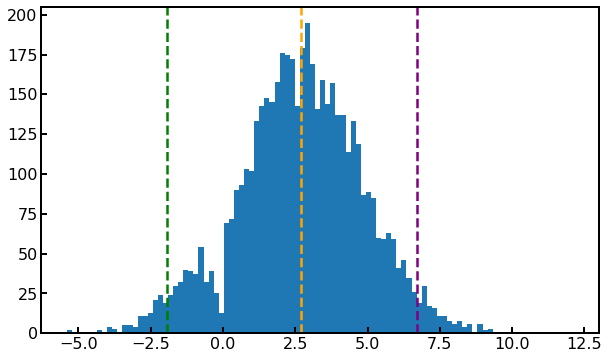

In [50]:
plt.figure(figsize=(10, 6))
weirddata = alldata[alldata['SUBJECT'] == 's13']
sorteddata = sorted(weirddata['BOOTSTRAP_VALUES'])
mean = np.mean(weirddata['BOOTSTRAP_VALUES'])

position_top = int(0.97*len(weirddata['BOOTSTRAP_VALUES']))
position_bottom = int(0.025*len(weirddata['BOOTSTRAP_VALUES']))

ci_low = sorteddata[position_bottom]
ci_up = sorteddata[position_top]


plt.hist(weirddata['BOOTSTRAP_VALUES'], 100)
plt.axvline(x=mean, linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.axvline(x=ci_low, linestyle='--', linewidth=2.5, label="lower bound 95% CI (sample_mean - 1.96*SE)", c='g')
plt.axvline(x=ci_up, linestyle='--', linewidth=2.5, label="upper bound 95% CI (sample_mean + 1.96*SE)", c='purple')


# Plot Fig 3 v2 

3 bars, for 1-back, 2-back and 3-back (group bootstrap)
on top of each bar, the boostrap means as mini circles

In [51]:
nTypes = ['1', '2', '3']
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

In [52]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

alldata_v2 = pd.DataFrame(columns=['SUBJECT', 'BOOTSTRAP_VALUES'])
ntype_data_trimed = pd.DataFrame()
ntype_data = pd.DataFrame()

row_type = 0
for ntype in nTypes:
    row = 0
    alldata_trimed_v2 = pd.DataFrame()
    for subject in subject_names:
        subjectdata_temp = pd.DataFrame()

        # load data:
        filename = datapath + subject + '/' + subject + '_VM_output_-' + ntype + 'nBack.csv'
        subjectdata = pd.read_csv(filename)
        subjectdata_temp['BOOTSTRAP_VALUES'] = subjectdata['bootstrap_values']
        subjectdata_temp.loc[:, 'SUBJECT'] = subject
        subjectdata_temp.loc[:, 'NTYPE'] = ntype

        print(subject)
        alldata_trimed_v2.loc[row,'SUBJECT'] = subject

        mean, ci_low, ci_up = mean_confidence_interval.confidence_interval_percentile(subjectdata['bootstrap_values'])
        
        alldata_trimed_v2.loc[row, 'NTYPE'] = ntype
        alldata_trimed_v2.loc[row, 'BOOTSTRAP_MEAN'] = mean
        alldata_trimed_v2.loc[row, 'BOOTSTRAP_CI_LOW'] = ci_low
        alldata_trimed_v2.loc[row, 'BOOTSTRAP_CI_UP'] = ci_up

#         if subject == 'S1':
#             alldata_v2 = subjectdata_temp
#         else:
#             alldata_v2 = pd.concat([alldata_v2, subjectdata_temp])

        row += 1
    
    if ntype == '1':
        ntype_data = alldata_trimed_v2
        
    else:
        ntype_data = pd.concat([ntype_data, alldata_trimed_v2])
        
    print(len(alldata_trimed_v2))
    mean_type, ci_low_type, ci_up_type = mean_confidence_interval.mean_confidence_interval(alldata_trimed_v2['BOOTSTRAP_MEAN'])
    ntype_data_trimed.loc[row_type, 'NTYPE'] = alldata_trimed_v2.NTYPE.unique()
    ntype_data_trimed.loc[row_type, 'NTYPE_MEAN'] = mean_type
    ntype_data_trimed.loc[row_type, 'NTYPE_CI_LOW'] = ci_low_type
    ntype_data_trimed.loc[row_type, 'NTYPE_CI_UP'] = ci_up_type
    
    row_type += 1
    

    
    
        


S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15
13
S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15
13
S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15
13


In [53]:
alldata_ci_v2 = pd.DataFrame(columns= nTypes)
for i in range(len(ntype_data_trimed)):
    
    print(i)
    ntype = ntype_data_trimed.loc[i, 'NTYPE']
    low = ntype_data_trimed.loc[i, 'NTYPE_MEAN'] - ntype_data_trimed.loc[i, 'NTYPE_CI_LOW']
    up = ntype_data_trimed.loc[i, 'NTYPE_CI_UP'] - ntype_data_trimed.loc[i, 'NTYPE_MEAN'] 
    
    alldata_ci_v2.loc[0, ntype] = low
    alldata_ci_v2.loc[1, ntype] = up

0
1
2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


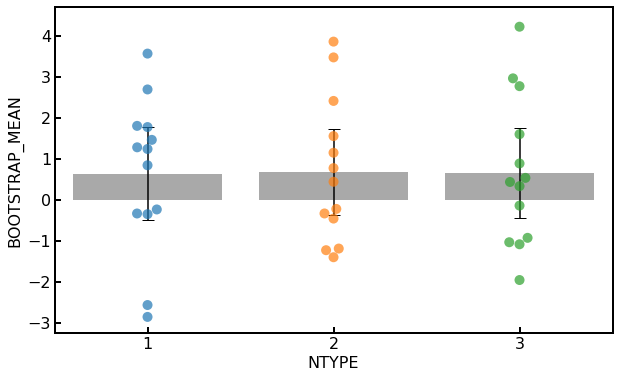

In [54]:
plt.figure(figsize=(10, 6))

plt.bar(ntype_data_trimed['NTYPE'], ntype_data_trimed['NTYPE_MEAN'], yerr=alldata_ci_v2.to_numpy(), ecolor='black',
       capsize=6, color = 'darkgray')
ax = sns.swarmplot(x='NTYPE', y="BOOTSTRAP_MEAN", data=ntype_data, dodge=True, size=10, alpha=0.7)
plt.savefig('TrialsForward_HalfAmplitude_radiologists_v2.eps', bbox_inches='tight', dpi=1200)
plt.savefig('TrialsForward_HalfAmplitude_radiologists_v2.svg', bbox_inches='tight', dpi=1200)

#  Plot Fig 3 v3

In [55]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']
nTypes = ['1', '2', '3']

# alldata_v2 = pd.DataFrame(columns=['SUBJECT', 'BOOTSTRAP_VALUES'])
# ntype_data_trimed = pd.DataFrame()
# bootstrap_data = pd.DataFrame(columns=)
bootstrap_data = pd.DataFrame()
row_subject = 0
for ntype in nTypes:
    for subject in subject_names:
        print(subject)
        subjectdata_temp = pd.DataFrame()

        # load data:
        filename = datapath + subject + '/' + subject + '_VM_output_-' + ntype + 'nBack.csv'
        subjectdata = pd.read_csv(filename)
        subjectdata_temp.loc[row_subject, 'SUBJECT'] = subject
        subjectdata_temp.loc[row_subject, 'TYPE'] = ntype

        for iteration in range(len(subjectdata['bootstrap_values'])):
            
            subjectdata_temp.loc[row_subject, str(iteration)] = subjectdata.loc[iteration, 'bootstrap_values']

#         alldata_trimed_v2.loc[row,'SUBJECT'] = subject

#         mean, ci_low, ci_up = mean_confidence_interval.confidence_interval_percentile(subjectdata['bootstrap_values'])
        
#         alldata_trimed_v2.loc[row, 'NTYPE'] = ntype
#         alldata_trimed_v2.loc[row, 'BOOTSTRAP_MEAN'] = mean
#         alldata_trimed_v2.loc[row, 'BOOTSTRAP_CI_LOW'] = ci_low
#         alldata_trimed_v2.loc[row, 'BOOTSTRAP_CI_UP'] = ci_up


    
        if (ntype == '1') & (subject == 'S1'):
            bootstrap_data = subjectdata_temp

        else:
            bootstrap_data = pd.concat([bootstrap_data, subjectdata_temp])
            
        row_subject += 1

        
    
#     mean_type, ci_low_type, ci_up_type = mean_confidence_interval.mean_confidence_interval(alldata_trimed_v2['BOOTSTRAP_MEAN'])
#     ntype_data_trimed.loc[row_type, 'NTYPE'] = alldata_trimed_v2.NTYPE.unique()
#     ntype_data_trimed.loc[row_type, 'NTYPE_MEAN'] = mean_type
#     ntype_data_trimed.loc[row_type, 'NTYPE_CI_LOW'] = ci_low_type
#     ntype_data_trimed.loc[row_type, 'NTYPE_CI_UP'] = ci_up_type
    
#     row_type += 1
    

    
    
        


S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15
S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15
S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


In [56]:
bootstrap_trimed = pd.DataFrame()

row = 0
for ntype in nTypes:
    
    print(ntype)
    type_data = bootstrap_data[bootstrap_data['TYPE'] == ntype]
    
    for iteration in range(5000):
        
        column = str(iteration)
        
        bootstrap_trimed.loc[row,'TYPE'] = ntype
        bootstrap_trimed.loc[row, column] = np.mean(type_data[column])
        
    
    row += 1

1
2
3


In [57]:
type_v3 = pd.DataFrame()
row=0
for ntype in nTypes:
    
    type_data = bootstrap_trimed[bootstrap_trimed['TYPE'] == ntype].reset_index(drop=True)
    mean, ci_low, ci_up = mean_confidence_interval.confidence_interval_percentile(type_data.iloc[0, 1:])
    
    type_v3.loc[row, 'TYPE'] = ntype
    type_v3.loc[row, 'MEAN'] = mean
    type_v3.loc[row, 'CI_LOW'] = ci_low
    type_v3.loc[row, 'CI_UP'] = ci_up
    
    row += 1
    

In [58]:
alldata_ci_v3 = pd.DataFrame(columns= nTypes)
for i in range(len(type_v3)):
    
    print(i)
    ntype = type_v3.loc[i, 'TYPE']
    low = type_v3.loc[i, 'MEAN'] - type_v3.loc[i, 'CI_LOW']
    up = type_v3.loc[i, 'CI_UP'] - type_v3.loc[i, 'MEAN'] 
    
    alldata_ci_v3.loc[0, ntype] = low
    alldata_ci_v3.loc[1, ntype] = up

0
1
2


In [59]:
boostrap_trimed_reorganized = pd.DataFrame()
row = 0
for ntype in nTypes:
    
    type_data = bootstrap_trimed[bootstrap_trimed['TYPE'] == ntype].reset_index(drop=True)

    for iteration in range(5000):
        
        
        boostrap_trimed_reorganized.loc[row, 'TYPE'] = ntype
        boostrap_trimed_reorganized.loc[row, 'BOOSTRAP_MEAN'] = type_data.loc[0, str(iteration)]
        
        
        row += 1
        
        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

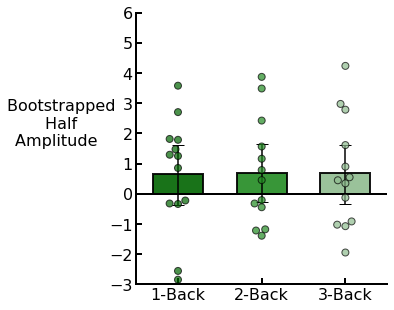

In [60]:
plt.figure(figsize=(4.5, 5))

plt.bar(type_v3['TYPE'], type_v3['MEAN'], yerr=alldata_ci_v3.to_numpy(), ecolor='black',
       capsize=6,color = ['darkgreen', 'forestgreen', 'darkseagreen'], edgecolor='k', alpha=0.9, width=0.6, linewidth=2)
# ax = sns.swarmplot(x='TYPE', y="BOOSTRAP_MEAN", data=boostrap_trimed_reorganized, dodge=True, size=10, alpha=0.7)
ax = sns.swarmplot(x='NTYPE', y="BOOTSTRAP_MEAN", data=ntype_data, dodge=True, size=7, alpha=0.7,edgecolor='k', linewidth=1, palette=['darkgreen', 'forestgreen', 'darkseagreen'])
sns.despine()
plt.ylabel('Bootstrapped                 \nHalf                 \nAmplitude                   ', rotation=0)
plt.xlabel('')
plt.ylim([-3, 6])
ax.set_xticklabels(['1-Back', '2-Back', '3-Back'])
plt.axhline(0, linestyle='-', linewidth=2, c='k')
sns.despine()
plt.yticks(np.arange(-3, 7, 1.0))
plt.savefig('TrialsForward_HalfAmplitude_radiologists_v3.eps', bbox_inches='tight', dpi=1200)
plt.savefig('TrialsForward_HalfAmplitude_radiologists_v3.svg', bbox_inches='tight', dpi=1200)
plt.savefig('TrialsForward_HalfAmplitude_radiologists_v3.jpg', bbox_inches='tight', dpi=1200)

## Test significance of bars 

0.8894


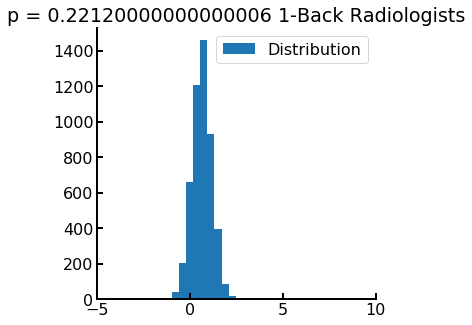

In [61]:
compDistributions.sigDistribution(bootstrap_trimed.iloc[0, 1:], extra_title=' 1-Back Radiologists', xlim=[-5, 10])

0.9156


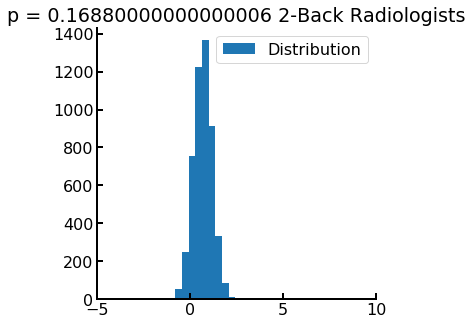

In [62]:
compDistributions.sigDistribution(bootstrap_trimed.iloc[1, 1:], extra_title=' 2-Back Radiologists', xlim=[-5, 10])

0.9044


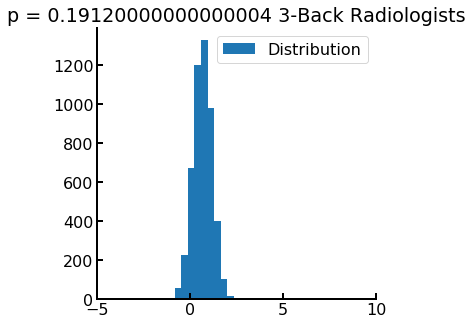

In [63]:
compDistributions.sigDistribution(bootstrap_trimed.iloc[2, 1:], extra_title=' 3-Back Radiologists', xlim=[-5, 10])

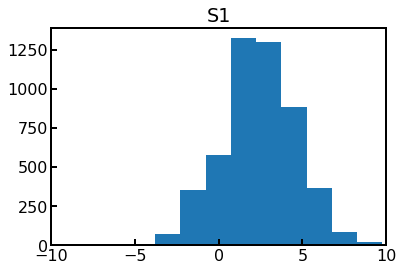

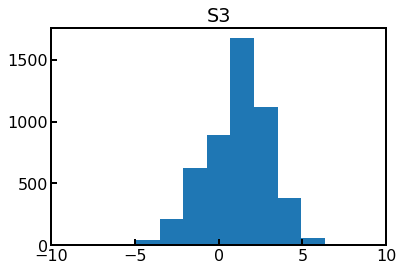

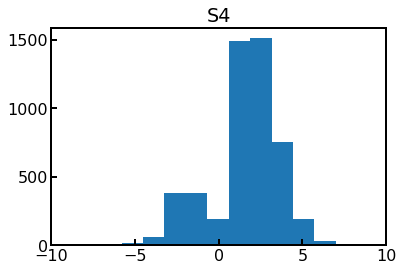

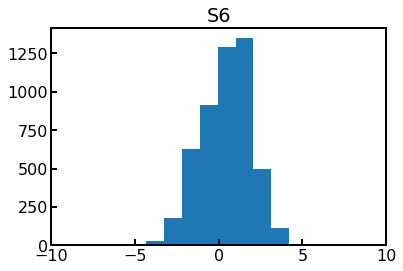

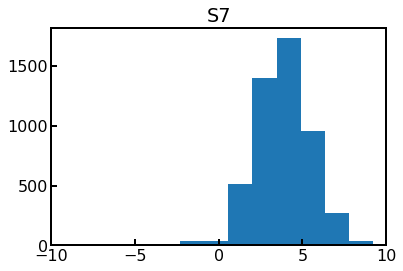

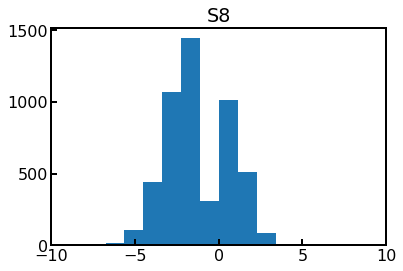

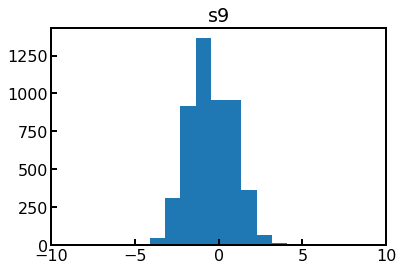

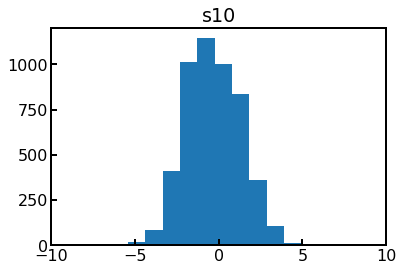

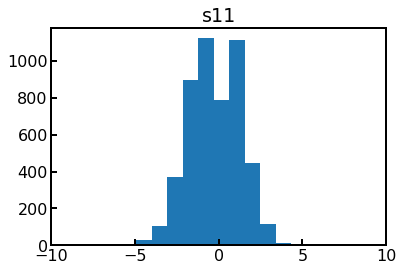

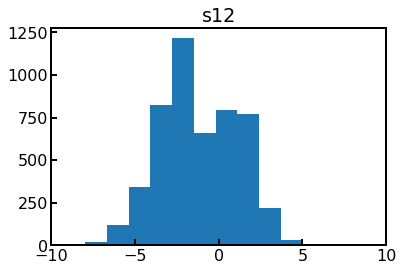

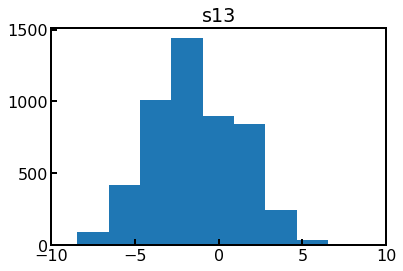

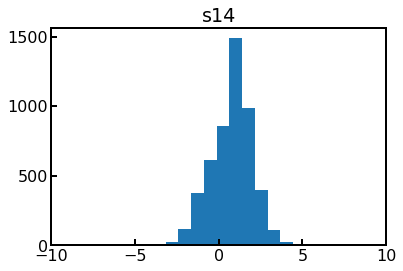

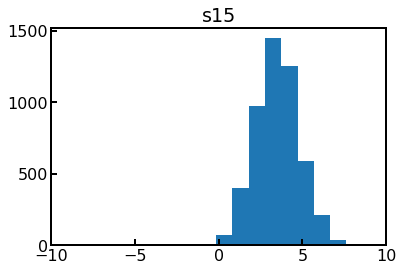

In [64]:
nBack2 = bootstrap_data[bootstrap_data['TYPE'] == '2']
for subject in nBack2.SUBJECT.unique():
    
    subdata = nBack2[nBack2['SUBJECT'] == subject].reset_index(drop=True)
    plt.hist(subdata.iloc[0, 2:])
    plt.title(subject)
    plt.xlim([-10, 10])
    plt.show()

## Run bootstrapped means 

In [65]:
nBack2_means = ntype_data[ntype_data['NTYPE'] == '2']
nBack2_means

,SUBJECT,NTYPE,BOOTSTRAP_MEAN,BOOTSTRAP_CI_LOW,BOOTSTRAP_CI_UP
0,S1,2,2.421630,-1.904475,6.444896
1,S3,2,1.157909,-2.760075,4.360235
2,S4,2,1.563532,-2.899739,4.771057
3,S6,2,0.449556,-2.537063,3.064202
4,S7,2,3.868420,0.856072,6.889315
5,S8,2,-1.219547,-4.450442,2.006337
6,s9,2,-0.448117,-2.860760,1.933180
7,s10,2,-0.323826,-3.227555,2.724820
8,s11,2,-0.212808,-3.123592,2.405390
9,s12,2,-1.179823,-5.463050,2.741187


0.5384615384615384


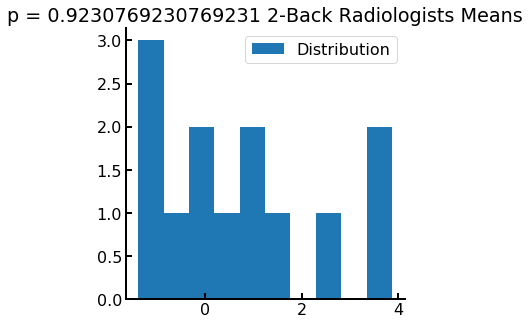

In [66]:
compDistributions.sigDistribution(nBack2_means['BOOTSTRAP_MEAN'], extra_title=' 2-Back Radiologists Means')

In [67]:
nIterations = 5000
nSubjects = len(nBack2_means['BOOTSTRAP_MEAN'])
iteration_means = list()
iteration_df = pd.DataFrame()

row = 0
for iteration in range(nIterations):
    iteration_sample = random.choices(nBack2_means['BOOTSTRAP_MEAN'], k=nSubjects)
    iteration_means.append(np.mean(iteration_sample))
    iteration_df.loc[iteration, 'MEAN'] = np.mean(iteration_sample)

0.9322


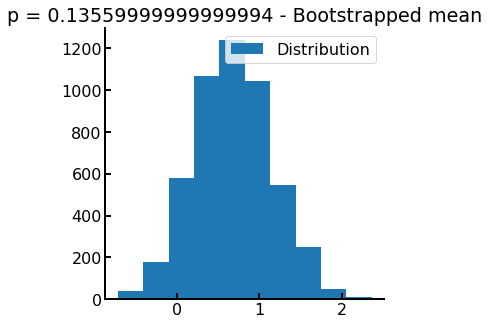

In [68]:
compDistributions.sigDistribution(iteration_df['MEAN'], extra_title=' - Bootstrapped mean')